In [1]:
# Create directory
# $ mkdir my_log_dir

# To access http://localhost:6006
# $tensorboard --logdir=mlogs

In [2]:
# Load the TensorBoard notebook extension
# %load_ext tensorboard

In [3]:
# supress warnings
import warnings
warnings.filterwarnings("ignore")

# import tensorflow and keras
import tensorflow 
from tensorflow import keras

# check the tensorflow and keras version
print(f" TensorFlow version is {tensorflow.__version__} \n Keras version is {tensorflow.keras.__version__}")

2024-05-31 11:02:58.530551: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


 TensorFlow version is 2.16.1 
 Keras version is 3.3.3


In [4]:
import logging
logging.getLogger('tensorflow').setLevel(logging.CRITICAL)

In [5]:
# base libraries
import os
import random
import numpy as np
import pandas as pd
import datetime
from pathlib import Path

# scikit-learn modules
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# tensorflow modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# plotting & outputs
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

from pprint import pprint

In [6]:
def set_seeds(seed=2022): 
    random.seed(seed)
    np.random.seed(seed)
    tensorflow.random.set_seed(seed)

In [7]:
# create sample dataset
X = np.array([i+1 for i in range(60)])

In [8]:
# reshape into 3D
X = np.array(X).reshape(20,3,1)

In [9]:
print(f'X: {X}')

X: [[[ 1]
  [ 2]
  [ 3]]

 [[ 4]
  [ 5]
  [ 6]]

 [[ 7]
  [ 8]
  [ 9]]

 [[10]
  [11]
  [12]]

 [[13]
  [14]
  [15]]

 [[16]
  [17]
  [18]]

 [[19]
  [20]
  [21]]

 [[22]
  [23]
  [24]]

 [[25]
  [26]
  [27]]

 [[28]
  [29]
  [30]]

 [[31]
  [32]
  [33]]

 [[34]
  [35]
  [36]]

 [[37]
  [38]
  [39]]

 [[40]
  [41]
  [42]]

 [[43]
  [44]
  [45]]

 [[46]
  [47]
  [48]]

 [[49]
  [50]
  [51]]

 [[52]
  [53]
  [54]]

 [[55]
  [56]
  [57]]

 [[58]
  [59]
  [60]]]


In [10]:
# check the shape
X.shape

(20, 3, 1)

In [11]:
# y is the sum of the values in the timesteps
y = []
for each in X:
    y.append(each.sum())
    
# convert to array
y = np.array(y)

# check the output
print(f'y: {y}')

y: [  6  15  24  33  42  51  60  69  78  87  96 105 114 123 132 141 150 159
 168 177]


In [12]:
# check the shape
y.shape

(20,)

In [13]:
# compile model five
nn = Sequential()
nn.add(LSTM(50, activation='relu', input_shape=(3, 1)))
nn.add(Dense(1))
nn.compile(optimizer='adam', loss='mse')
print(nn.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

None


In [14]:
# fit model
nn.fit(X, y, batch_size=64, epochs=1000, validation_split=0.2, verbose=0)

In [15]:
# predict the outcome
test_input = np.array([70,71,72])
test_input = test_input.reshape((1, 3, 1))
test_output = nn.predict(test_input, verbose=0)
print(test_output)

[[213.11786]]


In [16]:
results_path = Path('results', 'lstm_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [18]:
# Get the dataset from https://github.com/kannansingaravelu/datasets/blob/main/spy.csv
# Read data from the locally stored file
data = pd.read_csv('spy.csv', index_col=0, parse_dates=True)[['Adj Close']]['2000':'2019']

In [19]:
# Check the shape - has to be 2D
data.shape

(5031, 1)

In [20]:
# Check for missing values
data.isna().sum()

Adj Close    0
dtype: int64

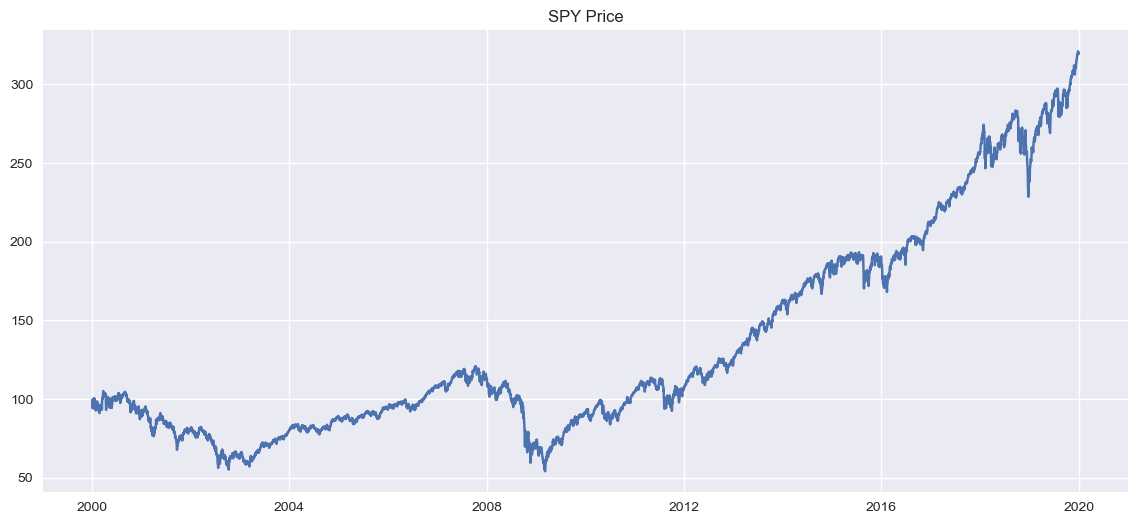

In [21]:
# Visualization 
plt.figure(figsize=(14,6))
plt.title('SPY Price')
plt.plot(data);

In [ ]:
# Splitting the datasets into training and testing data.
train_data, test_data = train_test_split(data, train_size=0.8, test_size=0.2, shuffle=False)

# Output the train and test data size
print(f"Train and Test Size {len(train_data)}, {len(test_data)}")

In [ ]:
# Scale the features MinMax for training and test datasets
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [ ]:
# sequence length
lookback = 60

In [ ]:
def generate_sequence(data, sequence_length=lookback):
    
    # create X & y data array
    X = []
    y = []

    for i in range(sequence_length, len(data)):
        X.append(data[i - sequence_length:i, 0])
        y.append(data[i, 0])
    
    # Converting x_train and y_train to Numpy arrays
    return np.array(X), np.array(y)

In [ ]:
X_train, y_train = generate_sequence(data=scaled_train_data, sequence_length=lookback)
print(f'X_train: {X_train.shape}, y_train {y_train.shape}')

In [ ]:
X_test, y_test = generate_sequence(data=scaled_test_data, sequence_length=lookback)
print(f'X_test: {X_test.shape}, y_test {y_test.shape}')

In [ ]:
# reshaping array
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = y_train[:, np.newaxis] 

# check the array size
print(f'X_train Shape: {X_train.shape}, y_train {y_train.shape}')

In [ ]:
# reshaping array
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = y_test[:, np.newaxis] 

# check the array size
print(f'X_test Shape: {X_test.shape}, y_test {y_test.shape}')

In [ ]:
# Create a model
def create_model(hu=256, lookback=60):

    tensorflow.keras.backend.clear_session()   
    
    # using functional api
    inputs = Input(shape=(lookback, 1))
    lstm = LSTM(units=hu, activation = 'relu', return_sequences=False, name='LSTM')(inputs)
    output = Dense(units=1, name='Output')(lstm)
    model = Model(inputs=inputs, outputs=output)

    # specify optimizer separately (preferred method))
    # opt = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)
    # adam optimizer seems to perform better for a single lstm
    opt = Adam(learning_rate=0.001, epsilon=1e-08)      
    
    # model compilation
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    
    return model

In [ ]:
# lstm network
model = create_model(hu=10, lookback=lookback)

In [ ]:
# summary
model.summary()

In [ ]:
plot_model(model, to_file='./images/model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Specify callback functions
model_path = (results_path / 'model.keras').as_posix()
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

my_callbacks = [
    EarlyStopping(patience=10, monitor='loss', mode='min', verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath=model_path, verbose=1, monitor='loss', save_best_only=True),
    TensorBoard(log_dir=logdir, histogram_freq=1)
]

In [ ]:
# Model fitting
history = model.fit(X_train, 
                    y_train, 
                    batch_size=64, 
                    epochs=500, 
                    verbose=1,
                    callbacks=my_callbacks, 
                    shuffle=False)

In [ ]:
# Plot training loss
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss');

In [ ]:
# %tensorboard --logdir logs

In [ ]:
# Create a basic model instance
basemodel = create_model()

In [ ]:
# Evaluate the model
loss, acc = np.sqrt(basemodel.evaluate(X_test, y_test, verbose=0))
print("Untrained model, loss: {:5.2f}".format(loss))

In [ ]:
# Loads the weights
new_model = tensorflow.keras.models.load_model('results/lstm_time_series/model.keras')

# Show the model architecture
new_model.summary()

In [ ]:
# Re-evaluate the model
loss, acc = np.sqrt(new_model.evaluate(X_test, y_test, verbose=0))
print("Restored model, loss: {:5.2f}".format(loss))

In [ ]:
# calculate rmse of loss function of base model
train_rmse_scaled = np.sqrt(basemodel.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(basemodel.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled[0]:.4f} | Test RMSE: {test_rmse_scaled[0]:.4f}')

In [ ]:
# calculate rmse of loss function of best model
train_rmse_scaled = np.sqrt(new_model.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(new_model.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled[0]:.4f} | Test RMSE: {test_rmse_scaled[0]:.4f}')

In [ ]:
# predictions
y_pred = new_model.predict(X_test)

In [ ]:
df = pd.DataFrame({
    'actual': scaler.inverse_transform(y_test).flatten(),
    'prediction': scaler.inverse_transform(y_pred).flatten()}, 
    index = test_data[lookback:].index)

df['spread'] = df['prediction'] - df['actual']
df

In [ ]:
print(f'R-square: {r2_score(df.actual, df.prediction):0.4}')

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

ax[0].plot(df.actual, color='red', label='actual')
ax[0].plot(df.prediction, color='blue', label='prediction')
ax[1].hist(df.spread, bins=50, density=True, label='spread')

ax[0].legend()
ax[1].legend()

plt.suptitle('SPY LSTM Prediction');